In [ ]:
import sqlite3
import pandas as pd

import matplotlib.pyplot as plt


def fetch_data_from_db(symbol: str, timeframe: str, limit=1000):

    db_path = f"data/db_per_symbol/{symbol}.db"
    table_name = f"ohlcv_{timeframe}"

    conn = sqlite3.connect(db_path)
    query = f"SELECT time, open, high, low, close, volume FROM {table_name} ORDER BY time DESC LIMIT {limit}"

    df = pd.read_sql_query(query, conn)
    conn.close()

    # مرتب‌سازی بر اساس زمان صعودی (اگر نیاز باشه)
    df = df.sort_values(by="time").reset_index(drop=True)
    return df

# نمونه استفاده:
symbol = "BTCUSD"
timeframe = "H1"
df = fetch_data_from_db(symbol, timeframe, limit=1000)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df = df[['open', 'high', 'low', 'close']].copy()
print(df.head())


                          open       high        low      close
time                                                           
2025-06-13 07:00:00  104277.21  104506.35  103783.06  104404.51
2025-06-13 08:00:00  104404.51  104449.99  104000.00  104002.25
2025-06-13 09:00:00  104002.25  104722.49  103825.11  104704.26
2025-06-13 10:00:00  104704.26  104970.11  104376.43  104895.00
2025-06-13 11:00:00  104895.00  105434.33  104694.77  104739.44


In [2]:
from price_action.swing_points import SwingPointDetector
analys = SwingPointDetector(symbol , timeframe)
analys.calculate(df)

,swing_high,swing_low,structure,bos,choch
time,,,,,
2025-06-13 07:00:00,NaN,NaN,,,NaN
2025-06-13 08:00:00,NaN,NaN,,,NaN
2025-06-13 09:00:00,NaN,NaN,,,NaN
2025-06-13 10:00:00,NaN,NaN,,,NaN
2025-06-13 11:00:00,105434.33,NaN,,,NaN
...,...,...,...,...,...
2025-07-24 18:00:00,119449.99,NaN,HH,BoS ↓,CHoCH ↓
2025-07-24 19:00:00,NaN,NaN,,,NaN
2025-07-24 20:00:00,NaN,NaN,,,NaN


In [3]:
import matplotlib.pyplot as plt

def plot_price_action_structure(df):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # کندل‌ها
    ax.plot(df.index, df['close'], label='Close', color='black', linewidth=1)

    # نمایش swing high و low
    ax.scatter(df.index, df['swing_high'], color='green', marker='^', label='Swing High', zorder=3)
    ax.scatter(df.index, df['swing_low'], color='red', marker='v', label='Swing Low', zorder=3)

    # نمایش ساختار HH, HL, LH, LL با اتصال خطوط بین آن‌ها
    last_point = None
    for i, row in df.iterrows():
        structure = row.get('structure', '')
        if structure in ['HH', 'HL', 'LH', 'LL']:
            y = row['swing_high'] if structure in ['HH', 'LH'] else row['swing_low']
            ax.text(i, y, structure, fontsize=9, color='purple', ha='center', va='bottom', fontweight='bold')
            if last_point:
                ax.plot([last_point[0], i], [last_point[1], y], color='gray', linestyle='--', linewidth=1)
            last_point = (i, y)

    # نمایش Break of Structure
    for i, row in df.iterrows():
        bos = row.get('bos', '')
        if bos in ['BoS ↓', 'BoS ↑']:
            y = row['close']
            color = 'blue' if bos == 'BoS ↓' else 'orange'
            offset = 0.01 * df['close'].max()
            y_offset = y + offset if bos == 'BoS ↓' else y - offset
            ax.text(i, y_offset, bos, fontsize=9, color=color, ha='center', va='top', fontweight='bold', zorder=5)

    for i, row in df.iterrows():
        bos = row.get('choch', '')
        if bos in ['CHoCH ↓', 'CHoCH ↑']:
            y = row['close']
            color = 'red' if bos == 'CHoCH ↓' else 'green'
            offset = 0.01 * df['close'].max()
            y_offset = y + offset if bos == 'BoS ↓' else y - offset
            ax.text(i, y_offset, bos, fontsize=9, color=color, ha='center', va='top', fontweight='bold', zorder=5)


    ax.set_title("Market Structure: HH/HL/LH/LL & Break of Structure (BoS)")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


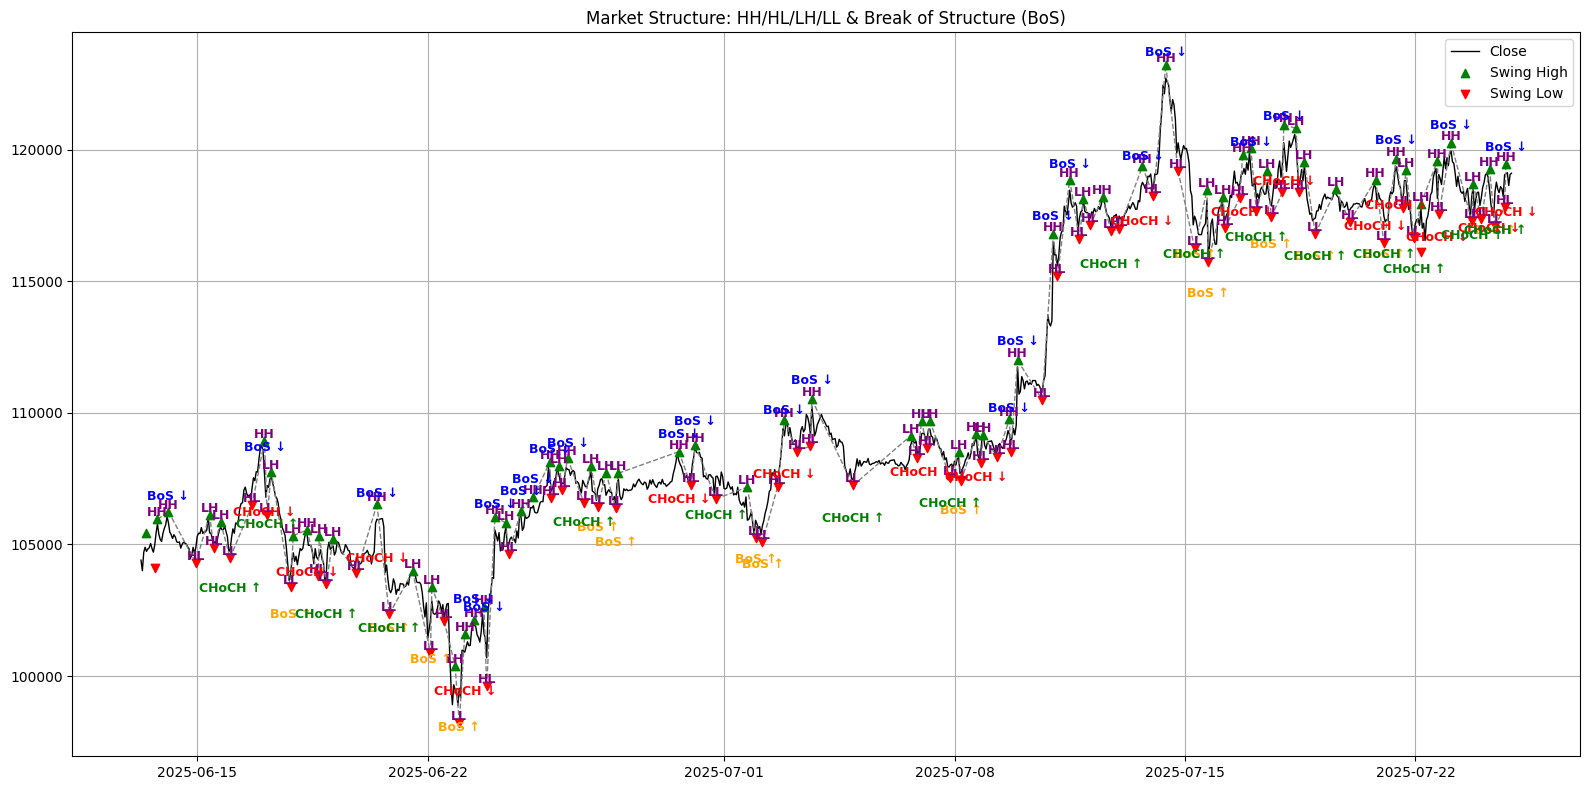

In [4]:
from price_action.swing_points import SwingPointDetector

# اجرای تحلیل
analys = SwingPointDetector(symbol, timeframe)
df_result = analys.calculate(df)

# اضافه کردن نتیجه به df اصلی (اگر calculate فقط بخشی از ستون‌ها را برگردانده بود)
df[df_result.columns] = df_result

# رسم نمودار
plot_price_action_structure(df)



In [10]:
print(df['bos'].value_counts(dropna=False))


bos
         998
BoS ↓      1
BoS ↑      1
Name: count, dtype: int64


In [11]:
df['bos'].value_counts()



bos
         998
BoS ↓      1
BoS ↑      1
Name: count, dtype: int64